In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
import joblib

In [2]:
def load_data(file_path='dados_credito.xlsx'):
    """
    Carrega os dados do arquivo Excel.

    Parameters:
    - file_path (str): Caminho do arquivo Excel.

    Returns:
    - pd.DataFrame: DataFrame contendo os dados.
    """
    df = pd.read_excel(file_path)
    df.drop('CODIGO_CLIENTE', axis=1, inplace=True)
    return df

In [3]:
def preprocess_data(df):
    """
    Realiza o pré-processamento dos dados, incluindo tratamento de nulos e outliers.

    Parameters:
    - df (pd.DataFrame): DataFrame contendo os dados.

    Returns:
    - pd.DataFrame: DataFrame pré-processado.
    """
    df['ULTIMO_SALARIO'].replace('SEM DADOS', np.nan, inplace=True)
    df['ULTIMO_SALARIO'] = df['ULTIMO_SALARIO'].astype(float)
    df['ULTIMO_SALARIO'].fillna(df['ULTIMO_SALARIO'].median(), inplace=True)

    outliers_qt_filhos = df[df['QT_FILHOS'] > 4]
    df.drop(outliers_qt_filhos.index, inplace=True)

    for coluna in val_num:
        print(df[coluna].groupby(df[coluna]).size(), '\n')

    # Criar a coluna 'FAIXA_ETARIA' antes de codificar dados categóricos
    df['FAIXA_ETARIA'] = pd.cut(df['IDADE'], bins=[0, 30, 40, 50, 60, np.inf], labels=['18-30', '31-40', '41-50', '51-60', '60+'])
    
    return df

In [4]:
def visualize_numeric_data(df):
    """
    Cria visualizações para variáveis numéricas, incluindo boxplots e histogramas.

    Parameters:
    - df (pd.DataFrame): DataFrame contendo os dados.
    """
    plt.figure(figsize=(20, 15))
    plt.autolayout = True
    f, axes = plt.subplots(2, 5, figsize=(20, 15))

    lin = 0
    col = 0
    for coluna in val_num:
        sns.boxplot(data=df, y=coluna, ax=axes[lin, col])
        col += 1
        if col == 5:
            lin += 1
            col = 0

    plt.show()

    plt.figure(figsize=(20, 15))
    plt.autolayout = True
    f, axes = plt.subplots(4, 3, figsize=(20, 15))

    lin = 0
    col = 0
    for coluna in val_num:
        sns.histplot(data=df, x=coluna, ax=axes[lin, col])
        col += 1
        if col == 3:
            lin += 1
            col = 0

    plt.show()

In [5]:
def visualize_categorical_data(df):
    """
    Cria visualizações para variáveis categóricas, incluindo countplots.

    Parameters:
    - df (pd.DataFrame): DataFrame contendo os dados.
    """
    val_cat = df.select_dtypes(include=['object', 'category']).columns
    plt.figure(figsize=(20, 15))
    plt.autolayout = True
    f, axes = plt.subplots(len(val_cat) // 3 + (len(val_cat) % 3 > 0), 3, figsize=(20, 15))

    lin = 0
    col = 0
    for coluna in val_cat:
        sns.countplot(data=df, x=coluna, ax=axes[lin, col])
        col += 1
        if col == 3:
            lin += 1
            col = 0

    plt.show()

In [6]:
def encode_categorical_data(df):
    """
    Codifica variáveis categóricas e salva mapeamento reverso.

    Parameters:
    - df (pd.DataFrame): DataFrame contendo os dados.

    Returns:
    - pd.DataFrame: DataFrame com dados codificados.
    - dict: Mapeamento reverso.
    """
    mapeamento_reverso_dict = {}
    label_encoder = LabelEncoder()

    val_cat = df.select_dtypes(include=['object', 'category']).columns

    for coluna in val_cat:
        df[coluna] = label_encoder.fit_transform(df[coluna])
        mapeamento_reverso_dict[coluna] = {codigo: valor_original for valor_original, codigo in zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_))}

    df.dropna(inplace=True)
    return df, mapeamento_reverso_dict

In [7]:
def train_and_evaluate_model(df, k_folds=5):
    var_alvo = df['SCORE']
    var_pred = df.drop('SCORE', axis=1)

    X_train, X_test, y_train, y_test = train_test_split(var_pred, var_alvo, test_size=0.3, random_state=25)

    minmax = MinMaxScaler()
    X_train = minmax.fit_transform(X_train)
    X_test = minmax.transform(X_test)

    # Modelo Random Forest
    modelo_rf = RandomForestRegressor(random_state=25)

    # Validação cruzada
    scores = cross_val_score(modelo_rf, X_train, y_train, cv=k_folds, scoring='r2')
    print(f"R² médio na validação cruzada ({k_folds} folds): {np.mean(scores):.2%}")

    # Treinar o modelo no conjunto de treino completo
    modelo_rf.fit(X_train, y_train)
    # Obter importâncias das features
    importancias_features = modelo_rf.feature_importances_

    # Exibir importâncias das features
    for nome_feature, importancia in zip(var_pred.columns, importancias_features):
        print(f"{nome_feature}: {importancia}")

    # Avaliação no conjunto de teste
    y_pred = modelo_rf.predict(X_test)
    r2_teste = r2_score(y_test, y_pred)
    print(f"R² no conjunto de teste: {r2_teste:.2%}")

    # Salvar modelo treinado
    joblib.dump(modelo_rf, 'modelo_random_forest.pkl')

    return modelo_rf, minmax

In [8]:
def predict_new_data(modelo, novos_dados, minmax):
    novos_dados_reshaped = np.array(novos_dados).reshape(1, -1)
    novos_dados_normalized = minmax.transform(novos_dados_reshaped)
    score_previsto = modelo.predict(novos_dados_normalized)
    print(f"Score de crédito previsto para esse cliente: {score_previsto[0]:.2f}")


In [9]:
# Carregar dados
df = load_data()
# Verificar tipo das variáveis
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10476 entries, 0 to 10475
Data columns (total 16 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   UF                          10476 non-null  object 
 1   IDADE                       10476 non-null  int64  
 2   ESCOLARIDADE                10476 non-null  object 
 3   ESTADO_CIVIL                10476 non-null  object 
 4   QT_FILHOS                   10476 non-null  int64  
 5   CASA_PROPRIA                10476 non-null  object 
 6   QT_IMOVEIS                  10476 non-null  int64  
 7   VL_IMOVEIS                  10476 non-null  int64  
 8   OUTRA_RENDA                 10476 non-null  object 
 9   OUTRA_RENDA_VALOR           10476 non-null  int64  
 10  TEMPO_ULTIMO_EMPREGO_MESES  10476 non-null  int64  
 11  TRABALHANDO_ATUALMENTE      10476 non-null  object 
 12  ULTIMO_SALARIO              10474 non-null  object 
 13  QT_CARROS                   104

In [10]:
val_num = df.select_dtypes(exclude='object').columns
# Pré-processar dados
df = preprocess_data(df)

IDADE
19    558
23    630
25    559
26      1
27    541
28    631
29      1
30    631
31      1
32    631
33      1
34      1
35    631
36      1
37      1
38      1
39      1
40      1
41      1
42    649
45    647
48    773
51    774
53    558
55    558
57    558
62    558
65    576
Name: IDADE, dtype: int64 

QT_FILHOS
0    3329
1    3726
2    2303
3    1116
Name: QT_FILHOS, dtype: int64 

QT_IMOVEIS
0    4680
1    3761
2     989
3    1044
Name: QT_IMOVEIS, dtype: int64 

VL_IMOVEIS
0         4680
185000     612
220000     791
280000     522
340000     522
370000     792
450000     990
600000     521
700000     522
900000     522
Name: VL_IMOVEIS, dtype: int64 

OUTRA_RENDA_VALOR
0       8350
2400     468
3000     612
3200     522
4000     522
Name: OUTRA_RENDA_VALOR, dtype: int64 

TEMPO_ULTIMO_EMPREGO_MESES
8      846
9      792
12     522
14     792
15     521
18     791
19     612
22     792
25     468
30     792
48     468
75     522
80     522
90     522
93     522
120    468


<Figure size 2000x1500 with 0 Axes>

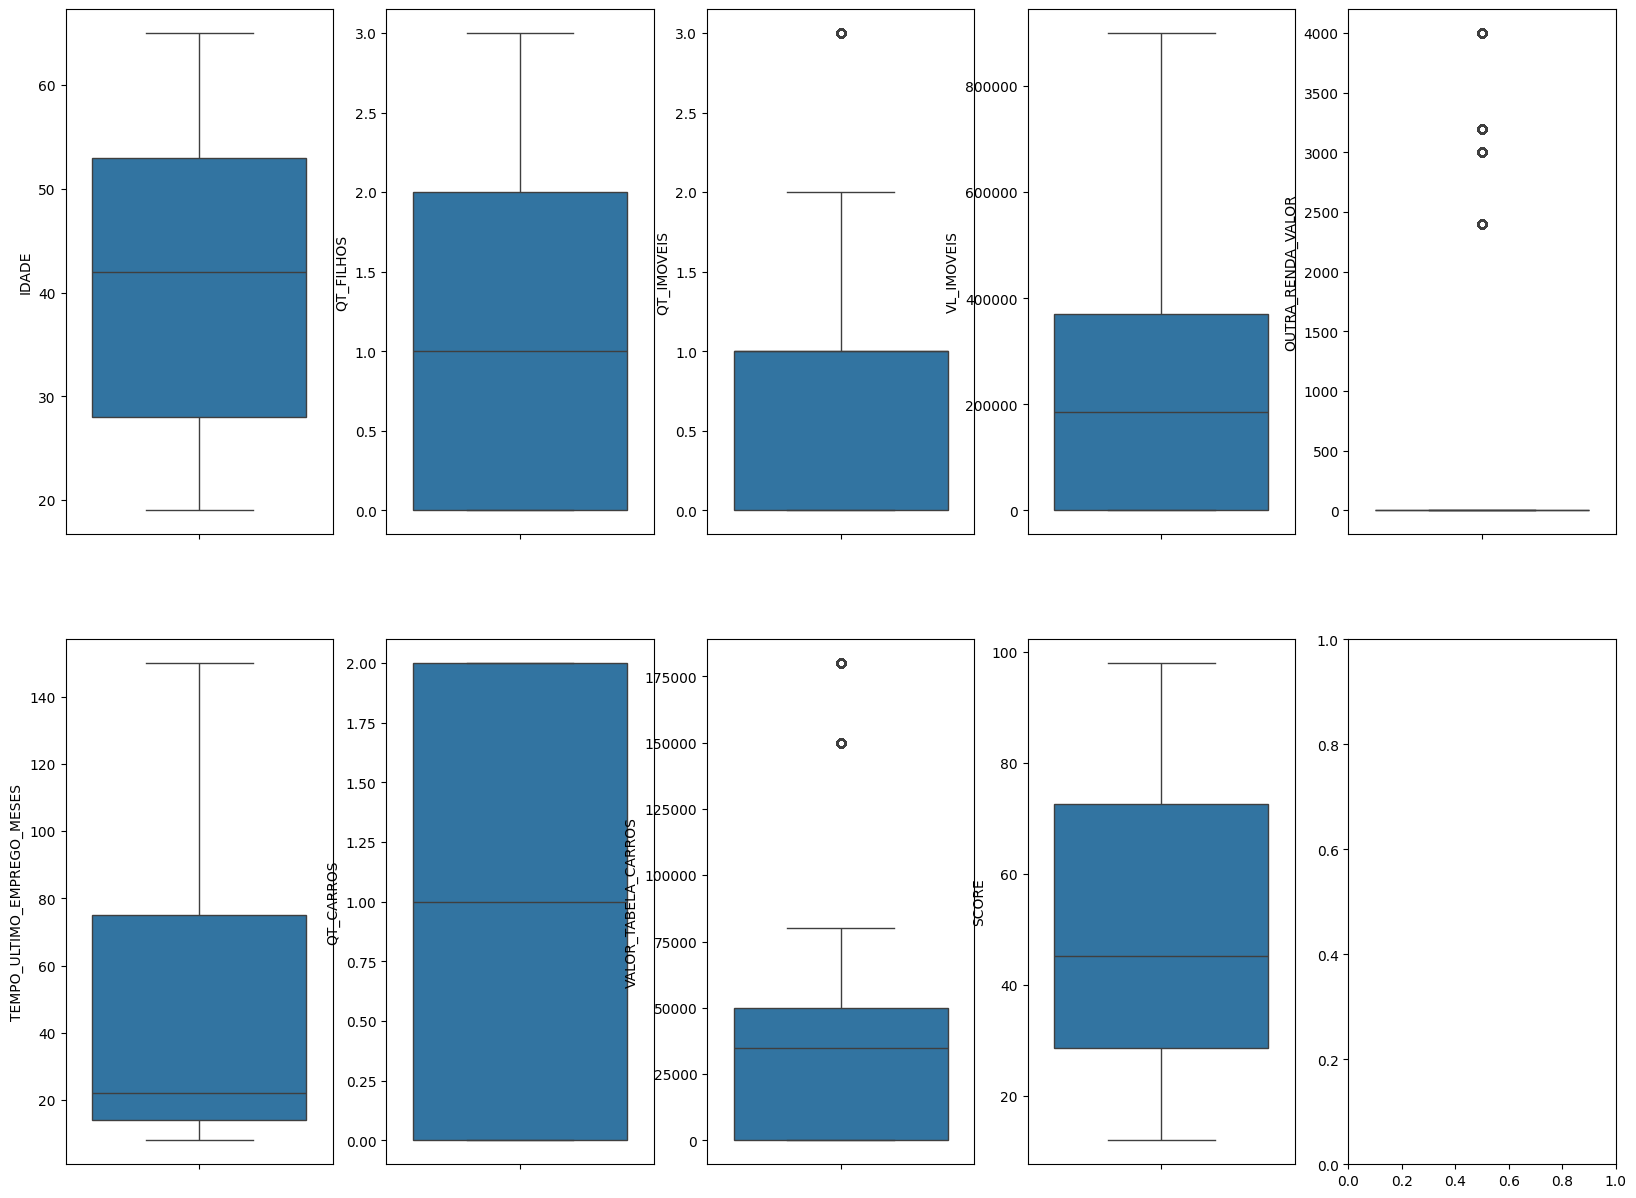

<Figure size 2000x1500 with 0 Axes>

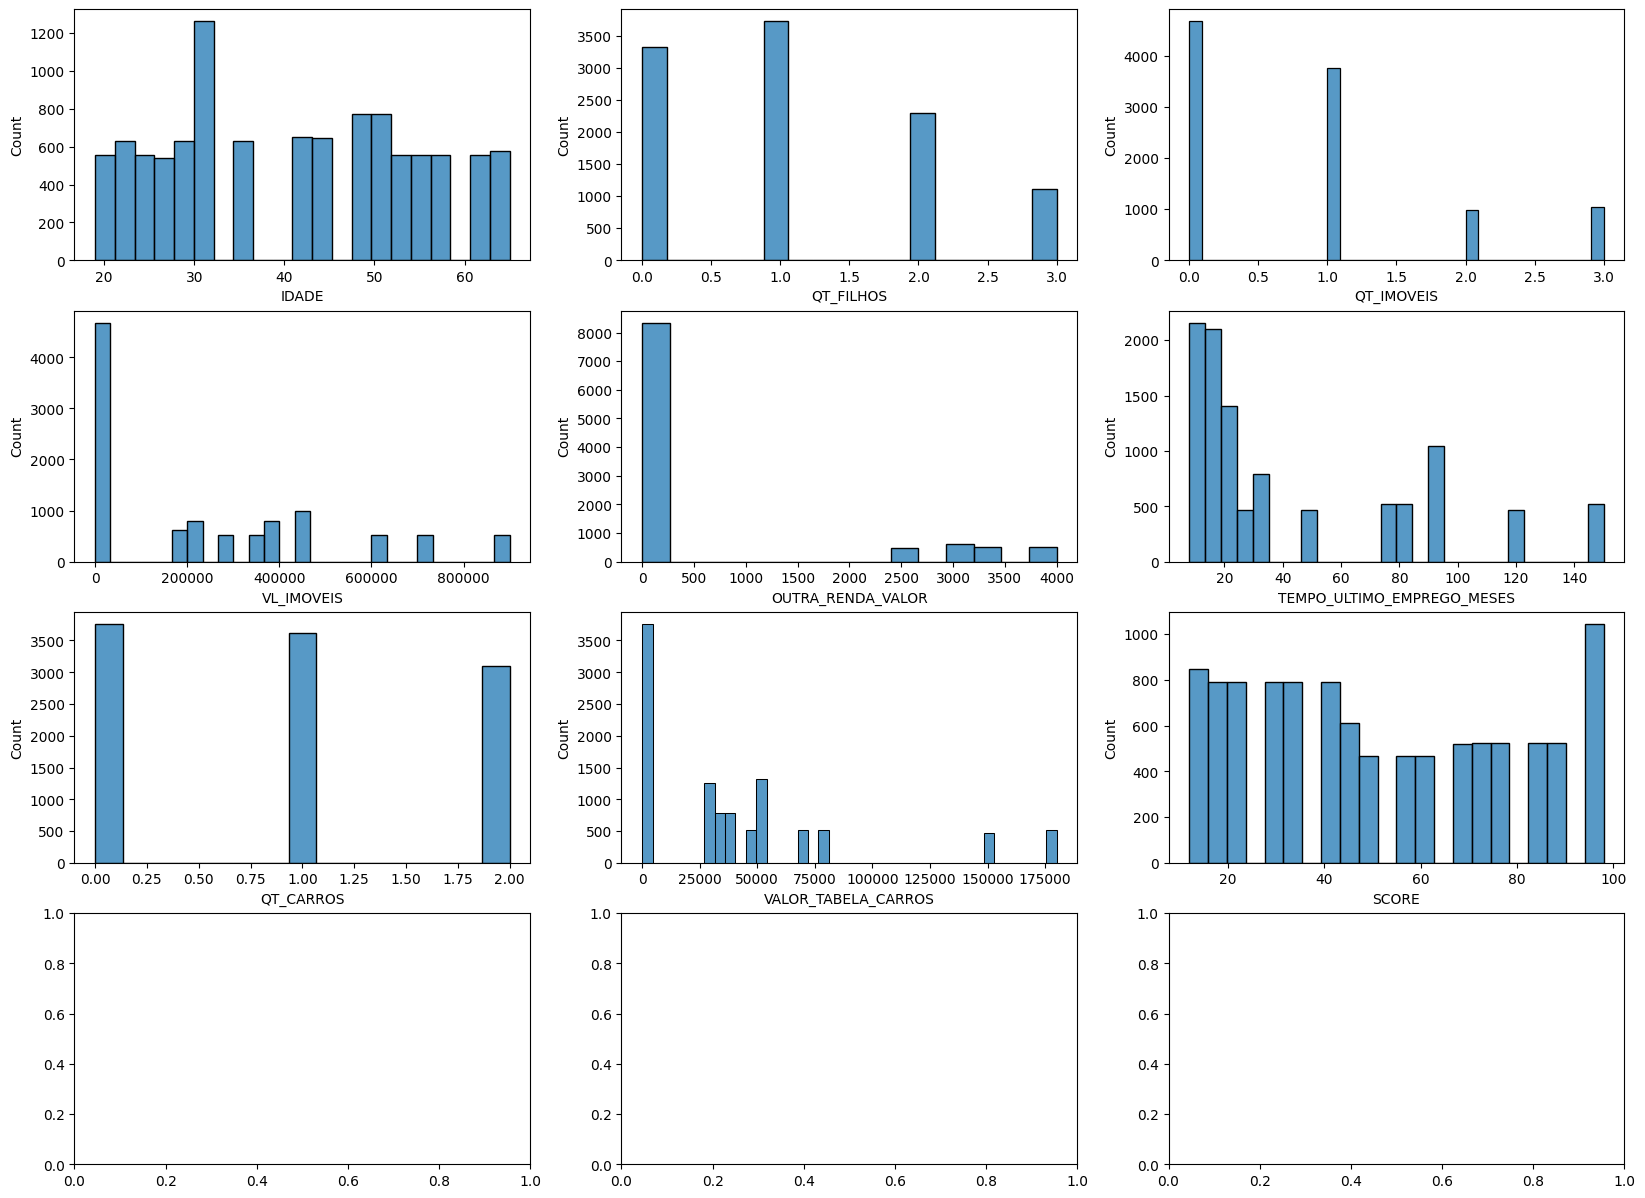

In [11]:
# Visualizar dados numéricos
visualize_numeric_data(df)

<Figure size 2000x1500 with 0 Axes>

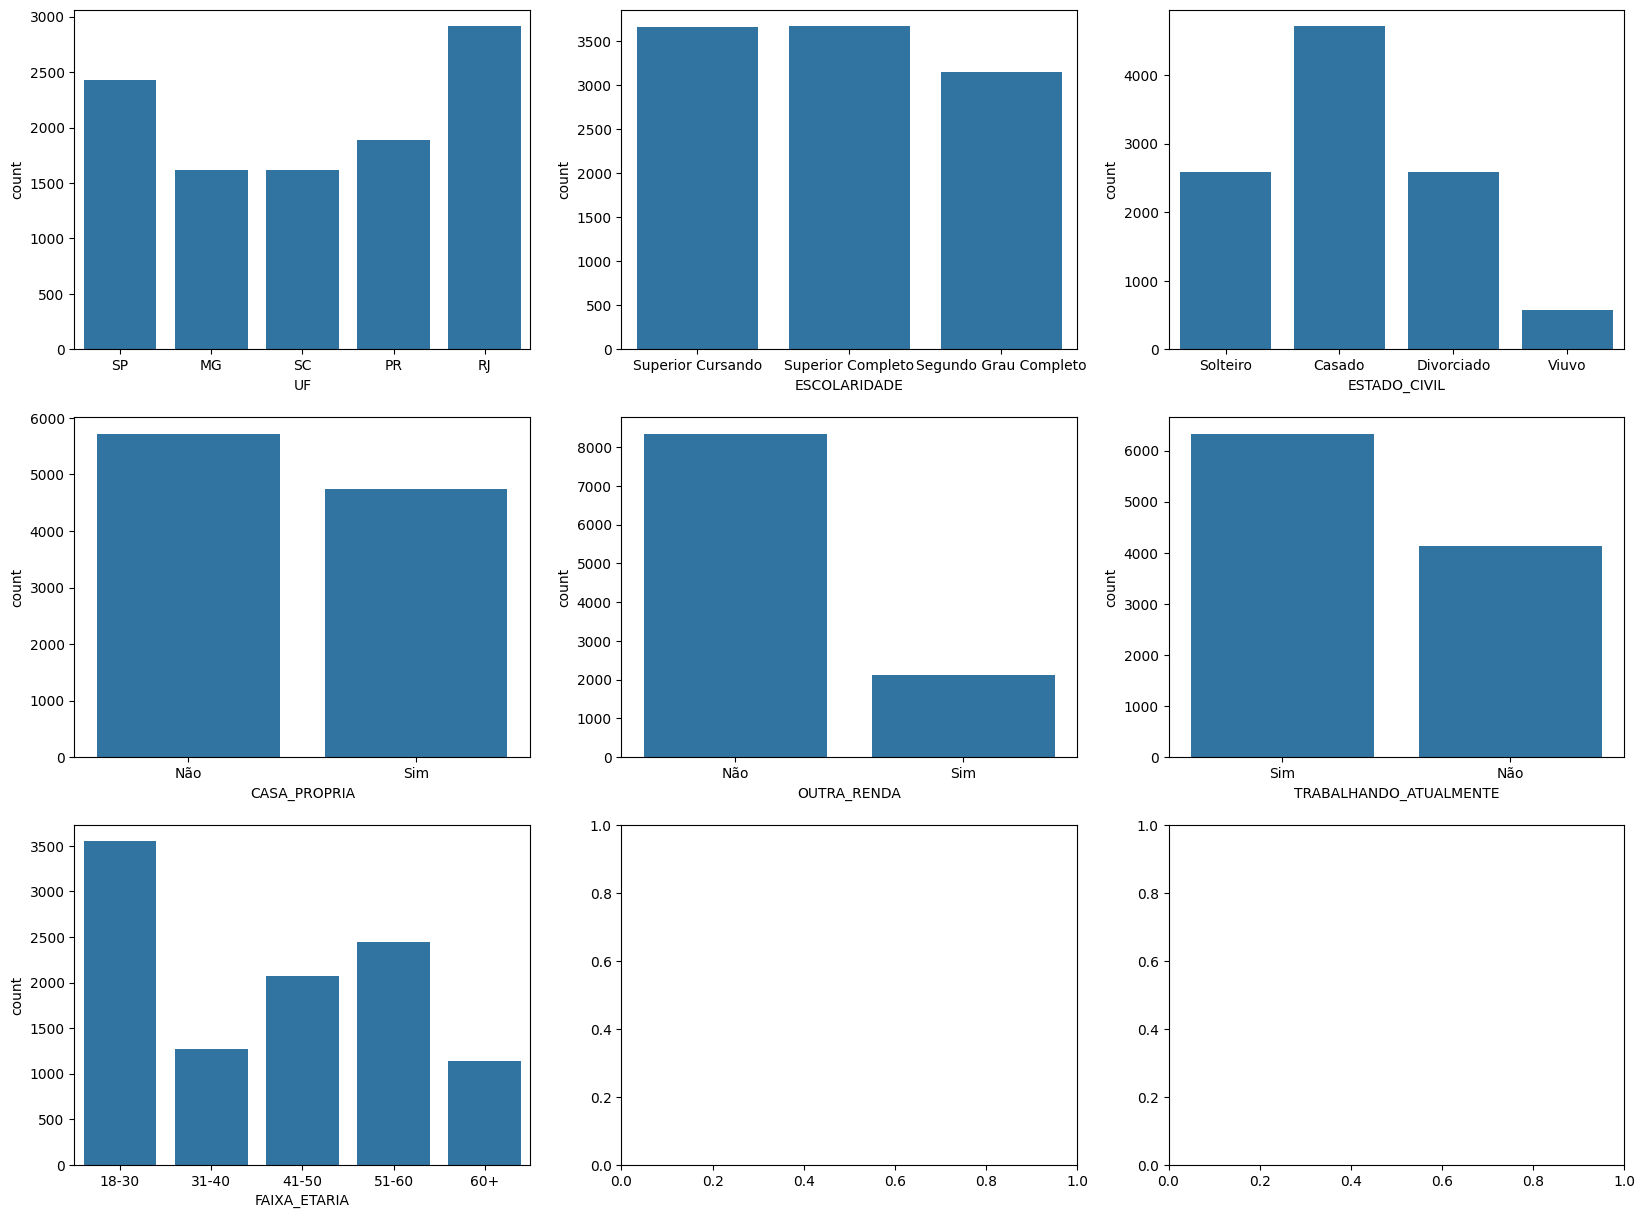

In [12]:
# Visualizar dados categóricos
visualize_categorical_data(df)

In [13]:
# Codificar dados categóricos
df, mapeamento_reverso_dict = encode_categorical_data(df)

In [14]:
# Exemplo de uso do mapeamento reverso
for coluna, mapeamento in mapeamento_reverso_dict.items():
    print(f"\nMapeamento reverso para {coluna}:")
    for codigo, valor_original in mapeamento.items():
        print(f"{codigo}: {valor_original}")


Mapeamento reverso para UF:
0: MG
1: PR
2: RJ
3: SC
4: SP

Mapeamento reverso para ESCOLARIDADE:
0: Segundo Grau Completo
1: Superior Completo
2: Superior Cursando

Mapeamento reverso para ESTADO_CIVIL:
0: Casado
1: Divorciado
2: Solteiro
3: Viuvo

Mapeamento reverso para CASA_PROPRIA:
0: Não
1: Sim

Mapeamento reverso para OUTRA_RENDA:
0: Não
1: Sim

Mapeamento reverso para TRABALHANDO_ATUALMENTE:
0: Não
1: Sim

Mapeamento reverso para FAIXA_ETARIA:
0: 18-30
1: 31-40
2: 41-50
3: 51-60
4: 60+


In [16]:
# Treinar e avaliar modelo Random Forest com validação cruzada
modelo_rf, minmax = train_and_evaluate_model(df)

R² médio na validação cruzada (5 folds): 100.00%
UF: 3.5783405681159765e-15
IDADE: 6.4119845201014086e-15
ESCOLARIDADE: 2.0485885666877165e-15
ESTADO_CIVIL: 1.6167807529697279e-15
QT_FILHOS: 2.996439257588145e-15
CASA_PROPRIA: 0.013062858256901668
QT_IMOVEIS: 0.025213943788501197
VL_IMOVEIS: 0.024694660278457597
OUTRA_RENDA: 5.8989601821870476e-05
OUTRA_RENDA_VALOR: 5.959790486490926e-05
TEMPO_ULTIMO_EMPREGO_MESES: 0.7758162896470534
TRABALHANDO_ATUALMENTE: 0.0004325608405220397
ULTIMO_SALARIO: 0.1562099921613601
QT_CARROS: 0.0013814390225537828
VALOR_TABELA_CARROS: 0.003069668497943782
FAIXA_ETARIA: 2.9718454907792557e-15
R² no conjunto de teste: 100.00%


In [17]:
# Testar o modelo com novos dados
novos_dados = [2, 36, 1, 2, 6, 1, 2, 300000, 1, 2000, 24, 0, 7400.0, 4, 70000, 3]
predict_new_data(modelo_rf, novos_dados, minmax)

Score de crédito previsto para esse cliente: 48.03


d:\Users\Higor\Documents\Anomalias_de_Codigo\modelo-preditivo-credito\.venv\lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
